# Import libraries

In [1]:
import os
import h5py
import matplotlib.pyplot as plt
import numpy as np
import numpy.matlib
from scipy import ndimage

# Change default figure size

In [2]:
plt.rcParams['figure.figsize'] = [12, 8]

# Define folder and filename of data

In [42]:
folder = '/Users/c.liebscher/Documents/PycharmProjects/ImageSimulations/2022/AI-STEM_TrainingData/simulationCells/HCP-Ti/'

files = [i for i in os.listdir(folder) if i.endswith("_FP12.hdf5")]
images = [os.path.join(folder, i) for i in files]

# Loop through simulated STEM reference images and rotate

In [43]:
for image in images:

    # Read simulated STEM image from hdf5 file
    file = h5py.File(image,'r')
    img = file.get('array')
    pixel_size = file.get('sampling') # in Angstrom
    units = file.get('units')
    #f.close()
    
    # Original image size
    Nx, Ny = img.shape
    
    # Specify replication of original simulated image for augmentation
    rep_img = 4
    
    # In case the original simulated STEM image is not square it will adapt the replication to make the image square
    if (Nx-Ny)>0:
        img_ratio = Nx/Ny
        rep_img = rep_img, int(rep_img*img_ratio)
    elif (Ny-Nx)>0:
        img_ratio = Ny/Nx
        rep_img = int(rep_img*img_ratio), rep_img
    else:
        rep_img = rep_img, rep_img
    
    # Replicate image
    img_rep = np.matlib.repmat(img, rep_img[0], rep_img[1])
    Nx_rep, Ny_rep = img_rep.shape
    
    # If image size is odd, make even in the corresponding direction by removing a one pixel boundary
    if (Nx_rep % 2) == 0:
        Nx_rep = Nx_rep
    else:
        img_rep = img_rep[:Nx_rep-1,:]
        
    if (Ny_rep % 2) == 0:
        Ny_rep = Ny_rep
    else:
        img_rep = img_rep[:,:Ny_rep-1]
        
    Nx_rep, Ny_rep = img_rep.shape
        
    # Specify the minimum and maximum rotation angles and the rotation increment
    rot_min = 0
    rot_max = 90
    rot_inc = 5
    rot_range = np.arange(rot_min,rot_max+rot_inc,rot_inc)
    
    # Specify the field of view of the rotated images in Angstrom, so that all images are cropped to that size
    fov = 12 # field of view in Angstrom

    # Prepare output array
    size_crop = int(np.round(fov/(np.round(pixel_size[0]*100)/100)))
    img_rotated = np.zeros((size_crop, size_crop, rot_range.size), dtype=float)
    Nx_rot, Ny_rot, Nz_rot = np.shape(img_rotated)

    for a0 in range(0, rot_range.size, 1):

        #Rotate images
        img_rotated_temp = ndimage.rotate(img_rep, rot_range[a0], reshape=False)

        #Crop image to maintain same field of view of here 1.2x1.2nm**2, if rectangular use smaller dimension
        #if (Nx-Ny) < 0:
        #    crop = Nxrep-Nx, Nyrep-Ny
        #elif (Nx-Ny) > 0:
        #    crop = int(np.round(((Nyrot*pixel_size[0]-fov)/pixel_size[0])/2))
        #else:
        #    crop = int(np.round(((Nxrot*pixel_size[0]-fov)/pixel_size[0])/2))
        
        crop = int((Nx_rep-Nx_rot)/2), int((Ny_rep-Ny_rot)/2)

        #Crop image
        img_rotated[:,:,a0] = img_rotated_temp[crop[0]:int(Nx_rep-crop[0]),crop[1]:int(Ny_rep-crop[1])]
        
    # Save to hdf5 file
    with h5py.File(image[:-5] + '_augmented_images_rotation.hdf5', 'a') as f_rotation:
        group_image_rotation = f_rotation.create_group('Image_rotation')
        group_image_rotation.create_dataset('Rotated_images', data=img_rotated)
        group_image_rotation.create_dataset('Rotation_angles', data=rot_range)
        
        # Create attributes
        group_image_rotation.attrs['Data description'] = ['Each simulated STEM image is roated by the rotation angles specified in Rotation_angles and is cropped to a field of view of 1.2nm x 1.2nm (here 100x100 pixels)']
        
    # Close hdf5 file(s)  
    file.close()

# Loop through rotated STEM images and add fast scan noise

### Fast scan noise is related to beam instabilities while scanning the sample line by line

In [44]:
for image in images:
    
    # Read augmented/rotated images
    file = h5py.File(image[:-5] + '_augmented_images_rotation.hdf5','r')

    # List groups in hdf5 file
    file_groups = file.keys()

    # Extract datasets for each group
    file_data = file.get('Image_rotation')
    img_rotated = file_data.get('Rotated_images')
    Nx, Ny, Nz = np.shape(img_rotated)
    number_rotated_imgs = Nz
    
    # Specify maximum line shift in pixels; each pixel line of the image in y-direction will be shifted randomly
    # by the specified shift to simulate fast scan noise
    line_shift_max = 3
    line_shift_range = np.arange(1,line_shift_max+1,1)
    
    # Set up array for images with fast scan noise for each rotation angle
    img_fastscan = np.zeros((Nx, Ny, number_rotated_imgs, line_shift_max), dtype=float)

    for a0 in range(0, 1, 1):

        # Original image size
        img = img_rotated[:,:,a0]
        Nx, Ny = np.shape(img)
        
        # Set up array of line shift values to store with image data
        line_shift = np.zeros((Nx, number_rotated_imgs), dtype=float)
        
        for b0 in range(0, line_shift_range.size, 1):
        
            # Randomly select line shift values between -line_shift_max and +line_shift_max
            line_shift[:,a0] = np.random.randint(-line_shift_range[b0], high=line_shift_range[b0], size=Nx, dtype=int)
            
            # Randomly shift each line of image by the line_shift values
            for c0 in range(0, Nx, 1):

                img_fastscan[c0,:,a0,b0] = np.roll(img[c0,:], int(line_shift[c0,a0]), axis=0)

    # Save to hdf5 file
    # Close file before writing new content
    file.close()
    with h5py.File(image[:-5] + '_augmented_images_rotation&fastscannoise.hdf5', 'a') as f_fastscan:
        group_image_fastscan = f_fastscan.create_group('Image_rotation_and_fast_scan_noise')
        group_image_fastscan.create_dataset('Rotated_and_noisy_images', data=img_fastscan)
        group_image_fastscan.create_dataset('Rotation_angles', data=rot_range)
        group_image_fastscan.create_dataset('Line_shift_in_pixels', data=line_shift)
        
        # Create attributes
        
        group_image_fastscan.attrs['Data description'] = ['Rotated_and_noisy_images dimensions: [0: image size x; 1: image size y; 2: rotation angles (rot_range); 3: noise level (line_shift)]']

# Loop through simulated and rotated STEM images and apply shear transformation

### Shear of the images is related to linear sample drift

In [45]:
from skimage.transform import warp, AffineTransform

for image in images:

    # Read simulated STEM image from hdf5 file
    file = h5py.File(image,'r')
    img = file.get('array')
    pixel_size = file.get('sampling') # in Angstrom
    units = file.get('units')
    #f.close()
    
    # Original image size
    Nx, Ny = img.shape
    
    # Specify replication of original simulated image for augmentation
    rep_img = 4
    
    # In case the original simulated STEM image is not square it will adapt the replication to make the image square
    if (Nx-Ny)>0:
        img_ratio = Nx/Ny
        rep_img = rep_img, int(rep_img*img_ratio)
    elif (Ny-Nx)>0:
        img_ratio = Ny/Nx
        rep_img = int(rep_img*img_ratio), rep_img
    else:
        rep_img = rep_img, rep_img
    
    # Replicate image
    img_rep = np.matlib.repmat(img, rep_img[0], rep_img[1])
    Nx_rep, Ny_rep = img_rep.shape
    
    # If image size is odd, make even in the corresponding direction by removing a one pixel boundary
    if (Nx_rep % 2) == 0:
        Nx_rep = Nx_rep
    else:
        img_rep = img_rep[:Nx_rep-1,:]
        
    if (Ny_rep % 2) == 0:
        Ny_rep = Ny_rep
    else:
        img_rep = img_rep[:,:Ny_rep-1]
        
    Nx_rep, Ny_rep = img_rep.shape
        
    # Specify the minimum and maximum rotation angles and the rotation increment
    rot_min = 0
    rot_max = 90
    rot_inc = 5
    rot_range = np.arange(rot_min,rot_max+rot_inc,rot_inc)
    
    # Specify the minimum and maximum shear to be applied
    shear_min = -0.05
    shear_max = 0.05
    shear_inc = 0.01
    shear_range = np.arange(shear_min,shear_max+shear_inc/2,shear_inc)
    shear_range = np.round(shear_range, decimals=2)
    
    # Specify the field of view of the rotated images in Angstrom, so that all images are cropped to that size
    fov = 12 # field of view in Angstrom

    # Prepare output array
    size_crop = int(np.round(fov/(np.round(pixel_size[0]*100)/100)))
    img_rotated_sheared = np.zeros((size_crop, size_crop, rot_range.size, shear_range.size), dtype=float)
    Nx_rot_shear, Ny_rot_shear, Nz_rot_shear, Ns_rot_shear = np.shape(img_rotated_sheared)
    
    ## Set up temporary array for rotated and sheared images
    #img_rotated_sheared_temp = np.zeros((Nx_rep, Ny_rep, shear_range.size), dtype=float)

    for a0 in range(0, rot_range.size, 1):

        #Rotate images
        img_rotated_temp = ndimage.rotate(img_rep, rot_range[a0], reshape=False)

        #Crop image to maintain same field of view of here 1.2x1.2nm**2, if rectangular use smaller dimension
        #if (Nx-Ny) < 0:
        #    crop = Nxrep-Nx, Nyrep-Ny
        #elif (Nx-Ny) > 0:
        #    crop = int(np.round(((Nyrot*pixel_size[0]-fov)/pixel_size[0])/2))
        #else:
        #    crop = int(np.round(((Nxrot*pixel_size[0]-fov)/pixel_size[0])/2))
        
        for b0 in range(0, shear_range.size, 1):
            
            tform = AffineTransform(scale=(1.0, 1.0), rotation=0, shear=shear_range[b0],
                        translation=(0, 0))
            img_rotated_sheared_temp = warp(img_rotated_temp, tform.inverse, output_shape=(Nx_rep, Ny_rep))

            #Crop image and write to array
            crop = int((Nx_rep-Nx_rot)/2), int((Ny_rep-Ny_rot)/2)
            img_rotated_sheared[:,:,a0,b0] = img_rotated_sheared_temp[crop[0]:int(Nx_rep-crop[0]),crop[1]:int(Ny_rep-crop[1])]
            
    # Save to hdf5 file
    with h5py.File(image[:-5] + '_augmented_images_rotation&shear.hdf5', 'a') as f_rotation_shear:
        group_image_rotation_shear = f_rotation_shear.create_group('Image_rotation_and_shear')
        group_image_rotation_shear.create_dataset('Rotated_and_sheared_images', data=img_rotated_sheared)
        group_image_rotation_shear.create_dataset('Rotation_angles', data=rot_range)
        group_image_rotation_shear.create_dataset('Shear_range',data=shear_range)
        
        # Create attributes
        group_image_rotation_shear.attrs['Data description'] = ['Rotated_and_sheared_images dimensions: [0: image size x; 1: image size y; 2: rotation angles (rot_range); 3: shear level (shear_range)]']
        
    # Close hdf5 file(s)  
    file.close()

# Loop through rotated and sheared STEM images and add fast scan noise

### Fast scan noise is related to beam instabilities while scanning the sample line by line

In [46]:
from skimage.transform import warp, AffineTransform

for image in images:
    
    # Read augmented/rotated images
    file = h5py.File(image[:-5] + '_augmented_images_rotation&shear.hdf5','r')

    # List groups in hdf5 file
    file_groups = file.keys()

    # Extract datasets for each group
    file_data = file.get('Image_rotation_and_shear')
    img_rotated_sheared = file_data.get('Rotated_and_sheared_images')
    Nx, Ny, Nrot, Nshear = np.shape(img_rotated_sheared)
    number_rotated_sheared_imgs = Nrot * Nshear
    
    # Specify maximum line shift in pixels; each pixel line of the image in y-direction will be shifted randomly
    # by the specified shift to simulate fast scan noise
    line_shift_max = 3
    line_shift_range = np.arange(0, line_shift_max+1, 1)
    
    # Set up array of line shift values to store with image data
    line_shift = np.zeros((Nx, number_rotated_sheared_imgs * line_shift_range.size), dtype=float)
    
    # Running variable
    i0 = 0
    i1 = 1 
    
    # Set up array for images with fast scan noise for each rotation angle
    img_fastscan = np.zeros((Nx, Ny, Nrot, Nshear, line_shift_max+1), dtype=float)

    for r0 in range(0, Nrot, 1):
        for s0 in range(0, Nshear, 1):
        
            img_fastscan_temp = img_rotated_sheared[:,:,r0,s0]         
        
            for f0 in range(0, line_shift_range.size, 1):
                
                # Running variable
                i0 = i0+i1
                i = i0-1
                
                # Randomly select line shift values between -line_shift_max and +line_shift_max
                if line_shift_range[f0]==0:
                    line_shift[:,i] = line_shift[:,i]
                else:
                    line_shift[:,i] = np.random.randint(-line_shift_range[f0], high=line_shift_range[f0]+1, size=Ny, dtype=int)
                
                # Randomly shift each line of image by the line_shift values
                for c0 in range(0, Ny, 1):
                    
                    img_fastscan[c0,:,r0,s0,f0] = np.roll(img_fastscan_temp[c0,:], int(line_shift[c0,i]), axis=0)

    # Save to hdf5 file
    # Close file before writing new content
    file.close()
    with h5py.File(image[:-5] + '_augmented_images_rotation&shear&fastscannoise.hdf5', 'a') as f_fastscan:
        group_image_fastscan = f_fastscan.create_group('Image_rotation_shear_and_fast_scan_noise')
        group_image_fastscan.create_dataset('Rotated_sheared_and_noisy_images', data=img_fastscan)
        group_image_fastscan.create_dataset('Rotation_angles', data=rot_range)
        group_image_fastscan.create_dataset('Shear_range', data=shear_range)
        group_image_fastscan.create_dataset('Line_shift_in_pixels', data=line_shift)
        
        # Create attributes
        group_image_fastscan.attrs['Data description'] = ['Rotated_sheared_and_noisy_images dimensions: [0: image size x; 1: image size y; 2: rotation angles (rot_range); 3: shear range (shear_range); 4: noise level (line_shift)]']

# Test selected augmented images

/Users/c.liebscher/Documents/PycharmProjects/ImageSimulations/2022/AI-STEM_TrainingData/simulationCells/HCP-Ti/HCP_Ti_10m10_LatPar_2.45A_t_80A_STEMsim_ps0.12_FP12.hdf5
<HDF5 dataset "Rotated_sheared_and_noisy_images": shape (100, 100, 19, 11, 4), type "<f8">


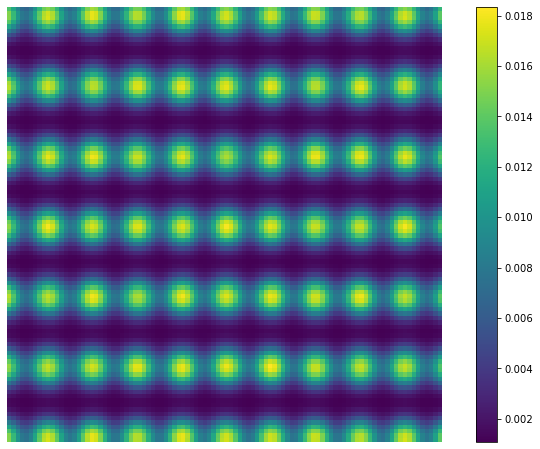

In [52]:
with h5py.File(images[30][:-5] + '_augmented_images_rotation&shear&fastscannoise.hdf5', 'a') as f:
    print(images[30])
    # Extract datasets for each group
    file_data = f.get('Image_rotation_shear_and_fast_scan_noise')
    img_data = file_data.get('Rotated_sheared_and_noisy_images')
    print(img_data)
    
    plt.imshow(img_data[:,:,0,5,0])
    plt.axis('off')
    plt.colorbar()
    plt.show()